In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Sampler, BatchSampler, Dataset, DataLoader, Subset, SubsetRandomSampler, random_split
import torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from matplotlib import pyplot as plt
import lmfit
from scipy import interpolate
from scipy import stats

In [2]:
def genData(iNS,iNB):
    sx=np.random.normal(0,0.5,iNS)
    sy=np.random.uniform(0.1,1,iNS)
    sz=np.random.triangular(0.,0.95, 1, iNS)
    s=np.vstack([sx,sy,sz])
    
    bx=np.random.uniform(-3,3,iNB)
    by=np.random.uniform(-1,-0.1,iNB)
    bz=np.random.triangular(0,0.05,1,iNB)
    b=np.vstack([bx,by,bz])
    return s,b

sig,bkg=genData(100,20000)

In [106]:
class DataSet(Dataset):
    def __init__(self, samples, labels):
        super(DataSet, self).__init__()
        self.labels  = labels
        self.samples = samples
        if len(samples) != len(labels):
            raise ValueError(
                f"should have the same number of samples({len(samples)}) as there are labels({len(labels)})")

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        y = self.labels[index]
        x = self.samples[index]
        return x, y

class simple_MLPFit_onelayer(torch.nn.Module):
    def __init__(self,in_data,input_size,out_channels=1,act_out=False,nhidden=16,batchnorm=False,batch_size=500,n_epochs=100):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, nhidden),
            nn.ReLU(),
            nn.Linear(nhidden, nhidden),
            nn.ReLU(),
            nn.Linear(nhidden, out_channels),
        )
        self.loss    = sigLoss()
        self.output  = torch.nn.Sigmoid()
        self.act_out = act_out
        self.batch_size = batch_size
        self.n_epochs     = n_epochs
        self.opt     = torch.optim.Adam(self.model.parameters(),lr=0.0002)
        self.dataloader = DataLoader(in_data, batch_size=self.batch_size, shuffle=True)#,pin_memory=True)
        
    def forward(self, x):
        x = self.model(x)        
        if self.act_out:
            x = self.output(x)
        return x
    
    def training_mse_epoch(self):
        running_loss = 0.0
        updates=0
        for batch_idx, (x, y) in enumerate(self.dataloader):
            self.opt.zero_grad()
            #x     = x.cuda(); y = y.cuda()
            #x = x.reshape((self.batch_size,1))
            x = x.reshape((len(x),1))
            x_out = self.forward(x)
            loss  = self.loss(x_out, y.flatten())
            loss.backward()
            self.opt.step()
            running_loss += loss 
            updates = updates+1
        return running_loss/updates

    def training_mse(self):
        for epoch in range(self.n_epochs):
            self.model.train(True)
            loss_train = self.training_mse_epoch()

            #self.model2.train(False)
            #loss_valid = self.validate_mse_epoch(self.model2,self.val_dataloader_mse())
            if epoch % 10 == 0:
                print('Epoch: {} LOSS train: {} '.format(epoch,loss_train))


def makeDataSet(iD,iNS,iNB):
    #1 is going to be sideband
    #2 is going to be mass range
    pD =  torch.from_numpy(iD.T)
    pXD =  pD[torch.randperm(len(pD))]
    tot=pXD[:,2]
    tot=tot.float()
    label=pXD[:,0]
    label=label.float()
    datatrain=DataSet(samples=tot,labels=label)
    return datatrain,pD[0:iNS].float(),pD[iNS-1:-1].float()



In [112]:
#import torchsort

def differentiable_histogram(x, weights, bins=10, min=-3.0, max=3.0):

    #if len(x.shape) == 4:
    #    n_samples, n_chns, _, _ = x.shape
    #elif len(x.shape) == 2:
    #    n_samples, n_chns = 1, 1
    #else:
    #    raise AssertionError('The dimension of input tensor should be 2 or 4.')
    n_samples, n_chns = 1, 1
    hist_torch = torch.zeros(n_samples, n_chns, bins).to(x.device)
    delta = (max - min) / bins

    BIN_Table = torch.range(start=0, end=bins, step=1) * delta + min

    for dim in range(1, bins+1, 1):
        h_r = BIN_Table[dim].item()             # h_r
        h_r_sub_1 = BIN_Table[dim - 1].item()   # h_(r-1)
        mask_sub = ((h_r > x) & (x >= h_r_sub_1)).float()
        mask_sub *= weights
        hist_torch[:, :, dim-1] += torch.sum((mask_sub).view(n_samples, n_chns, -1), dim=-1)        
    return hist_torch #/ delta

class sigLoss(torch.nn.Module):

    def __init__(self, sort_tolerance=1.0,sort_reg='l2'):
        super(sigLoss, self).__init__()
        self.tolerance = sort_tolerance
        self.reg       = sort_reg
        self.nbins     = 10
        self.xmin      = -3.0
        self.xmax      = 3.0 
        self.delta     = (self.xmax - self.xmin) / self.nbins
        self.BIN_Table = torch.range(start=0, end=self.nbins, step=1) * self.delta + self.xmin
        
    def forward(self, x, y):
        #loss = (1.0 - (torch.tanh (alpha * (x[1:] - x[:-1])) * torch.tanh (alpha * (y[1:] - y[:1])))).mean()
        #xsort=torchsort.soft_rank(x.reshape(1,-1))
        #xsort=torch.sort(x.reshape(1,-1))
        #xsort=torch.topk(x.reshape(1,-1), 25, dim=-1)
        #cut=xsort.values
        weight=0.5*(torch.tanh (5.0*(torch.sigmoid(x[:,0])-0.5))+1.0)
        #print("!",x,"W",weight)
        #sig = s/sqrt(s+b) 
        #yhist, bin_edges   = torch.histogram(y, bins=3,range=[-3,3],weight=weight,density=True)
        #ynorm   = torch.sum(weight*(y > -1)*(y < 1))
        #yvalues = (weight*(y > -1)*(y < 1)-0.5*weight*(y < -1)-0.5*weight*(y > 1))#
        #loss=10.0-torch.sum(yvalues)/torch.sqrt(ynorm)
        yhist = self.differentiable_histogram(y,weight).flatten()
        chi2sig=self.chi2loss(x,yhist,self.funcSig)
        chi2bkg=self.chi2loss(x,yhist,self.funcBkg)
        loss=chi2sig-chi2bkg
        return loss

    def differentiable_histogram(self, x, weights, bins=10, min=-3.0, max=3.0):
        hist_torch = torch.zeros(bins).to(x.device)
        for dim in range(1, self.nbins+1, 1):
            h_r = self.BIN_Table[dim].item()             # h_r
            h_r_sub_1 = self.BIN_Table[dim - 1].item()   # h_(r-1)
            mask_sub = ((h_r > x) & (x >= h_r_sub_1)).float()
            mask_sub *= weights
            hist_torch[dim-1] += torch.sum(mask_sub)
        return hist_torch #/ delta
    
    def funcSig(self,x,pars):
        val=-1*((x-pars[:,2])/pars[:,3])**2
        prob=torch.exp(val)
        return pars[:,1]*prob + pars[:,4]

    def funcBkg(self,x,pars):
        return pars[:,4]
    
    def chi2loss(self,x,y,iFunc):
        chi2=0
        for dim in range(1, self.nbins+1, 1):
            h_r = 0.5*(self.BIN_Table[dim].item() + self.BIN_Table[dim - 1].item()) 
            yval=iFunc(h_r,x)
            chi2+=(y[dim-1]-torch.mean(yval))**2
        return chi2
    
    def significance(self,iX,iY):
        print(iX,iY)
        NLL = deltaNLL(iX,iY,False)
        return NLL

val=torch.tensor(0.3)
print(0.5*(torch.tanh(10*(val-0.5))+1.0))

tensor(0.0180)


0.99921644


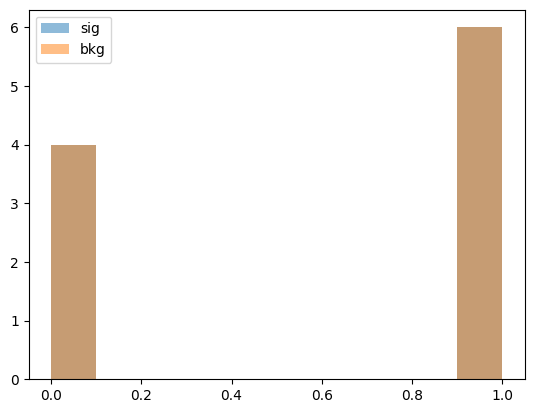

46 1963 100 20000


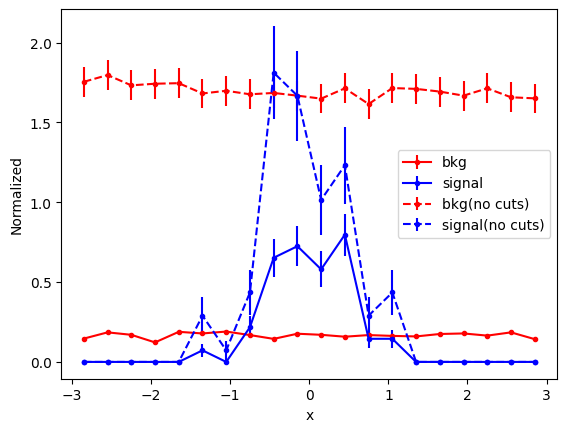

46 1963 100 20000


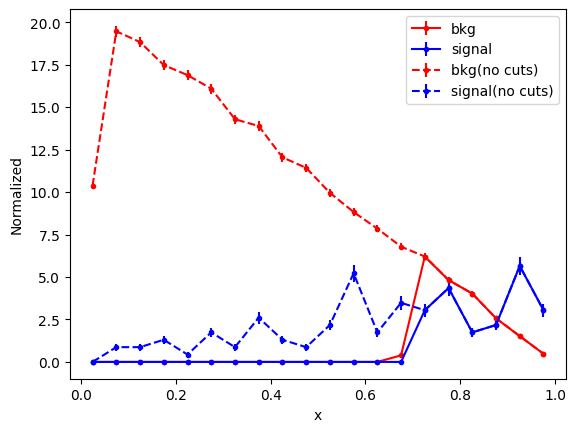

tensor([0.9999, 0.9994, 0.9998, 0.9999, 0.9999, 0.9999, 0.9996, 0.9998, 0.9998,
        0.9998, 0.9999, 0.9999, 0.9998, 0.9997, 0.9999, 0.9999, 0.9998, 0.9998,
        0.9998, 0.9997, 0.9997, 0.9998, 0.9998, 0.9999, 0.9998, 0.9998, 0.9998,
        0.9999, 0.9998, 0.9997, 0.9998, 0.9999, 0.9998, 0.9999, 0.9997, 0.9999,
        0.9998, 0.9998, 0.9996, 0.9996, 0.9998, 0.9998, 0.9999, 0.9998, 0.9998,
        0.9997, 0.9999, 0.9996, 0.9996, 0.9997, 0.9999, 0.9999, 0.9997, 0.9997,
        0.9994, 0.9999, 0.9999, 0.9999, 0.9993, 0.9997, 0.9994, 0.9999, 0.9999,
        0.9998, 0.9999, 0.9998, 0.9998, 0.9999, 0.9995, 0.9998, 0.9998, 0.9998,
        0.9999, 0.9996, 0.9999, 0.9998, 0.9994, 0.9999, 0.9998, 0.9999, 0.9999,
        0.9998, 0.9999, 0.9996, 0.9999, 0.9998, 0.9999, 0.9998, 0.9998, 0.9998,
        0.9998, 0.9999, 0.9997, 0.9998, 0.9999, 0.9995, 0.9998, 0.9999, 0.9998,
        0.9995], grad_fn=<SelectBackward0>) tensor([0.0176, 0.0394, 0.0239, 0.0192, 0.0177, 0.0181, 0.0334, 0.0239, 0.02

In [111]:
def cutval(iData, p=0.9):
    datasort=np.sort(iData)
    ndata=len(datasort)
    return datasort[int(ndata*p)]

def plotHistComp(iGSig,iGBkg,iSig,iBkg,iMin=-3,iMax=3):
    ns=len(iSig)
    nb=len(iBkg)
    ngs=len(iGSig)
    ngb=len(iGBkg)
    print(ns,nb,ngs,ngb)
    ys, bin_edges = np.histogram(iSig,density=True,bins=20,range=[iMin,iMax])#bins=bin_edges
    yb, bin_edges = np.histogram(iBkg, bins=bin_edges,density=True)
    ygs,bin_edges = np.histogram(iGSig, bins=bin_edges,density=True)
    ygb,bin_edges = np.histogram(iGBkg, bins=bin_edges,density=True)
    ygs*=len(iGSig)/len(iSig)
    ygb*=len(iGBkg)/len(iBkg)
    bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
    plt.errorbar(bin_centers,yb,yerr=(nb*yb)**0.5/nb,marker='.',linestyle = '-', color = 'red',label='bkg')
    plt.errorbar(bin_centers,ys,yerr=(ns*ys)**0.5/ns,marker='.',linestyle = '-', color = 'blue',label='signal')
    plt.errorbar(bin_centers,ygb,yerr=(ngb/nb)*((ngb*ygb)**0.5)/ngb,marker='.',linestyle = '--', color = 'red',label='bkg(no cuts)')
    plt.errorbar(bin_centers,ygs,yerr=(ngs/ns)*((ngs*ygs)**0.5)/ngs,marker='.',linestyle = '--', color = 'blue',label='signal(no cuts)')
    plt.xlabel("x")
    plt.ylabel("Normalized")
    plt.legend()
    plt.show()

def plotFit(iData,iDataOut,iMin=-3,iMax=3):
    lDisc = torch.mean(iData[:,0])
    lAmp  = torch.mean(iData[:,1])
    lMean = torch.mean(iData[:,2])
    lSig  = torch.mean(iData[:,3])
    lDogs = torch.mean(iData[:,3])
    
    
pdata = np.hstack((sig,bkg))
data,test_sig,test_bkg=makeDataSet(pdata,len(sig[0]),len(bkg[0]))
rw_model = simple_MLPFit_onelayer(data,1,out_channels=5,act_out=False,batchnorm=False)
rw_model.training_mse()
output_sig=rw_model.forward(test_sig[:,2].reshape(len(test_sig),1))
output_bkg=rw_model.forward(test_bkg[:,2].reshape(len(test_bkg),1))
output=torch.cat((output_sig,output_bkg))
cut=cutval(output[:,0].flatten().detach().numpy(),p=0.9)
print(cut)
_,bins,_=plt.hist(output_sig[:,0].flatten().detach().numpy(),density=True,alpha=0.5,label='sig')
plt.hist(output_bkg[:,0].flatten().detach().numpy(),density=True,alpha=0.5,label='bkg',bins=bins)
plt.legend()
plt.show()
cutsig = output_sig[:,0].flatten().detach().numpy() > cut
cutbkg = output_bkg[:,0].flatten().detach().numpy() > cut
plotHistComp(test_sig[:,0],test_bkg[:,0],test_sig[cutsig][:,0],test_bkg[cutbkg][:,0])
plotHistComp(test_sig[:,2],test_bkg[:,2],test_sig[cutsig][:,2],test_bkg[cutbkg][:,2],0,1)



/var/folders/4t/mwl83f3x1ls0jvy35v4qzj7c0000gp/T/ipykernel_50027/3646663467.py:13: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  BIN_Table = torch.range(start=0, end=bins, step=1) * delta + min


torch.Size([1, 1, 30])
None
tensor([  0.0000,  12.0000,  11.7647,  12.3529,  20.1176,  16.8236,  23.1765,
         26.4705,  20.0588,  36.2353,  61.0589,  61.4119,  66.0001,  86.8234,
         79.4704,  65.4117,  83.3531, 118.9413, 153.8829, 210.4710, 286.5290,
        254.5877, 250.7642, 291.2947, 472.6477, 501.5310, 525.5892, 692.9402,
        857.4691,   0.0000], grad_fn=<SliceBackward0>)


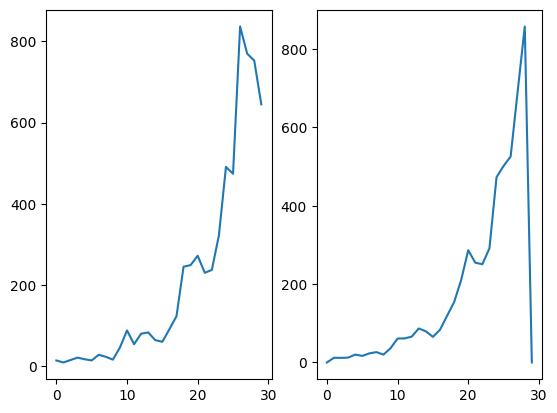

In [96]:
def differentiable_histogram(x, bins=255, min=0.0, max=0.5):

    if len(x.shape) == 4:
        n_samples, n_chns, _, _ = x.shape
    elif len(x.shape) == 2:
        n_samples, n_chns = 1, 1
    else:
        raise AssertionError('The dimension of input tensor should be 2 or 4.')

    hist_torch = torch.zeros(n_samples, n_chns, bins).to(x.device)
    delta = (max - min) / bins

    BIN_Table = torch.range(start=0, end=bins, step=1) * delta + min

    for dim in range(1, bins-1, 1):
        h_r = BIN_Table[dim].item()             # h_r
        h_r_sub_1 = BIN_Table[dim - 1].item()   # h_(r-1)
        h_r_plus_1 = BIN_Table[dim + 1].item()  # h_(r+1)

        mask_sub = ((h_r > x) & (x >= h_r_sub_1)).float()
        mask_plus = ((h_r_plus_1 > x) & (x >= h_r)).float()

        hist_torch[:, :, dim] += torch.sum(((x - h_r_sub_1) * mask_sub).view(n_samples, n_chns, -1), dim=-1)
        hist_torch[:, :, dim] += torch.sum(((h_r_plus_1 - x) * mask_plus).view(n_samples, n_chns, -1), dim=-1)

    print(hist_torch.shape)
    return hist_torch / delta


from PIL import Image

# Load image
src = Image.open('src.png').convert('L').resize((100, 100), Image.BILINEAR)
src = torch.Tensor(np.array(src) / 255.0)
src.requires_grad = True

# Compute histogram (official implementation)
hist_standard = torch.histc(src, bins=30, min=0.25, max=0.5)

# Compute histogram (differentiable implementation)
hist_differentiable = differentiable_histogram(src, bins=30, min=0.25, max=0.5)[0, 0, :]

# Backward Test
#try:
#    torch.mean(hist_standard).backward()     # Error
#except Exception as e:
#    print(e)
#torch.mean(hist_differentiable).backward()
print(src.grad)
print(hist_differentiable)
# Show
plt.figure()
plt.subplot(121)
plt.plot(hist_standard.detach().numpy())
plt.subplot(122)
plt.plot(hist_differentiable.detach().numpy())
plt.show()

In [74]:
torch.normal(mean=0.5, std=torch.ones(6))
dist = torch.distributions.normal.Normal(0.5, 1)
print(torch.exp(dist.log_prob(torch.Tensor(my_value))))

NameError: name 'my_value' is not defined